In [101]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [102]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/uae_nrel_data.csv'
# output_folder = 'assets/arch'
# os.makedirs(output_folder, exist_ok=True)

year=2022

time_step = 24
num_feats = 5
evaluation_results = []

neurons = 500
epochs = 20
batch_size = 64

In [103]:
# Modified evaluate_model function to store results in evaluation_results
def minmaxscaling():
    input_scaler = MinMaxScaler()
    output_scaler = MinMaxScaler()
    return input_scaler, output_scaler

def minmaxscaling_feature_range():
    input_scaler = MinMaxScaler(feature_range = (0,1))
    output_scaler = MinMaxScaler(feature_range = (0,1))
    return input_scaler, output_scaler

def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
# def create_dataset(dataset, time_step):
#     print(f'dataset shape {dataset.shape}')
#     dataX, dataY = [], []
#     for i in range(len(dataset) - time_step):
#         a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
#         dataX.append(a)
#         dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
#     return np.array(dataX), np.array(dataY)

def create_dataset (X, y, time_steps):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  save_path = os.path.join('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.show()
  plt.close()


def read_data():
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#   year = 2022
  data_2022 = data[data.index.year == year]
  data = data_2022[data_2022.index.month == 4]
  return data

In [104]:

data = read_data()

# data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
y = data[['GHI']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_50855/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [105]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler() 
y=scaler.fit_transform(np.array(y).reshape(-1,1))

In [106]:
training_size=int(len(y)*0.8)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:1]

In [107]:
training_size,test_size

(576, 144)

In [108]:
import numpy

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [109]:
time_step = 24
X_train, y_train = create_dataset(train_data, time_step) # apply create_dataset()
X_test, ytest = create_dataset(test_data, time_step)

In [110]:
print(X_train.shape), print(y_train.shape)

(551, 24)
(551,)


(None, None)

In [111]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [112]:
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=False)))
model.add(Dropout(0.6))
model.add(Dense(1)) # output layer
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [113]:
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, ytest), verbose=1)

Epoch 1/10
9/9 [==============================] - 2s 103ms/step - loss: 0.1341 - val_loss: 0.0818
Epoch 2/10
9/9 [==============================] - 1s 73ms/step - loss: 0.0703 - val_loss: 0.0319
Epoch 3/10
9/9 [==============================] - 1s 74ms/step - loss: 0.0221 - val_loss: 0.0081
Epoch 4/10
9/9 [==============================] - 1s 74ms/step - loss: 0.0129 - val_loss: 0.0062
Epoch 5/10
9/9 [==============================] - 1s 77ms/step - loss: 0.0087 - val_loss: 0.0063
Epoch 6/10
9/9 [==============================] - 1s 80ms/step - loss: 0.0080 - val_loss: 0.0053
Epoch 7/10
9/9 [==============================] - 1s 74ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 8/10
9/9 [==============================] - 1s 73ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 9/10
9/9 [==============================] - 1s 73ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 10/10
9/9 [==============================] - 1s 74ms/step - loss: 0.0070 - val_loss: 0.0047


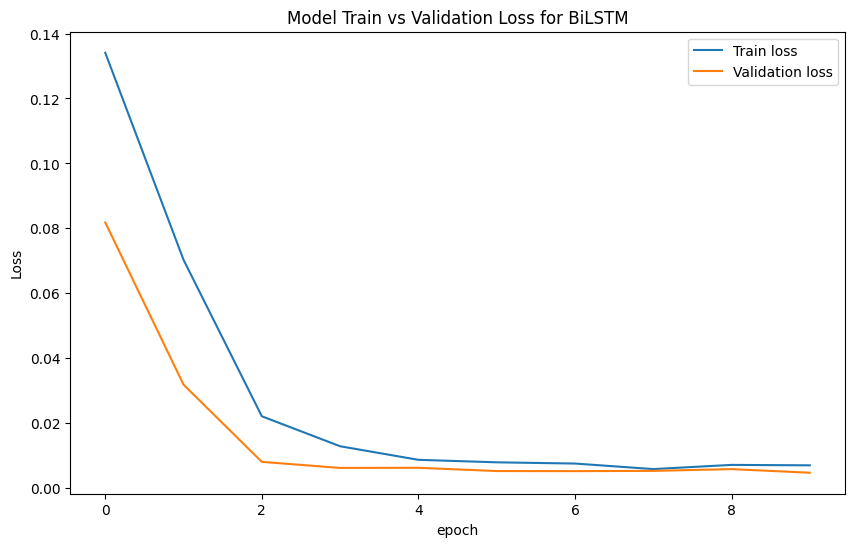

In [114]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'BiLSTM')

In [115]:
predicted_values = model.predict(X_test)


4/4 [==============================] - 0s 13ms/step


In [116]:
predicted_values = scaler.inverse_transform(predicted_values)
actual_values = scaler.inverse_transform(ytest.reshape(-1, 1))

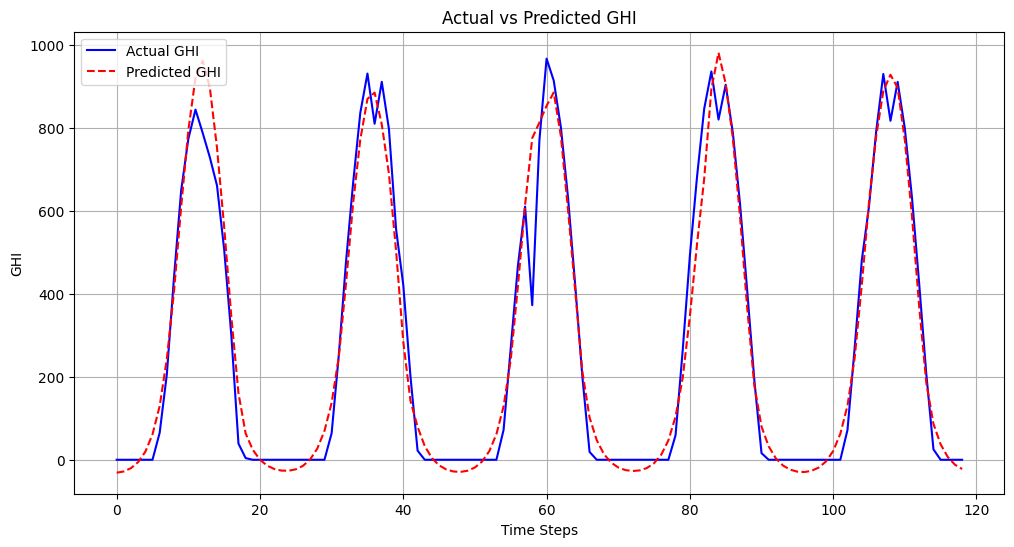

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_values, color='blue', label='Actual GHI')  # Actual values
plt.plot(predicted_values, color='red', linestyle='--', label='Predicted GHI')  # Predicted values
plt.xlabel("Time Steps")
plt.ylabel("GHI")
plt.title("Actual vs Predicted GHI")
plt.legend()
plt.grid(True)
plt.show()

In [118]:
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

In [119]:
evaluate_model(actual_values, predicted_values, 'BiLSTM', 'Testing')

In [120]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,46.547438,4747.917313,68.905133,0.9594


/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_50855/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Epoch 1/10
9/9 [==============================] - 5s 388ms/step - loss: 0.0280 - val_loss: 0.0298
Epoch 2/10
9/9 [==============================] - 3s 344ms/step - loss: 0.0080 - val_loss: 0.0252
Epoch 3/10
9/9 [==============================] - 4s 380ms/step - loss: 0.0061 - val_loss: 0.0211
Epoch 4/10
9/9 [==============================] - 4s 436ms/step - loss: 0.0051 - val_loss: 0.0159
Epoch 5/10
9/9 [==============================] - 3s 372ms/step - loss: 0.0041 - val_loss: 0.0134
Epoch 6/10
9/9 [==============================] - 3s 366ms/step - loss: 0.0035 - val_loss: 0.0131
Epoch 7/10
9/9 [==============================] - 3s 345ms/step - loss: 0.0037 - val_loss: 0.0113
Epoch 8/10
9/9 [==============================] - 3s 339ms/step - loss: 0.0029 - val_loss: 0.0108
Epoch 9/10
9/9 [==============================] - 3s 346ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 10/10
4/4 [==============================] - 0s 68ms/step


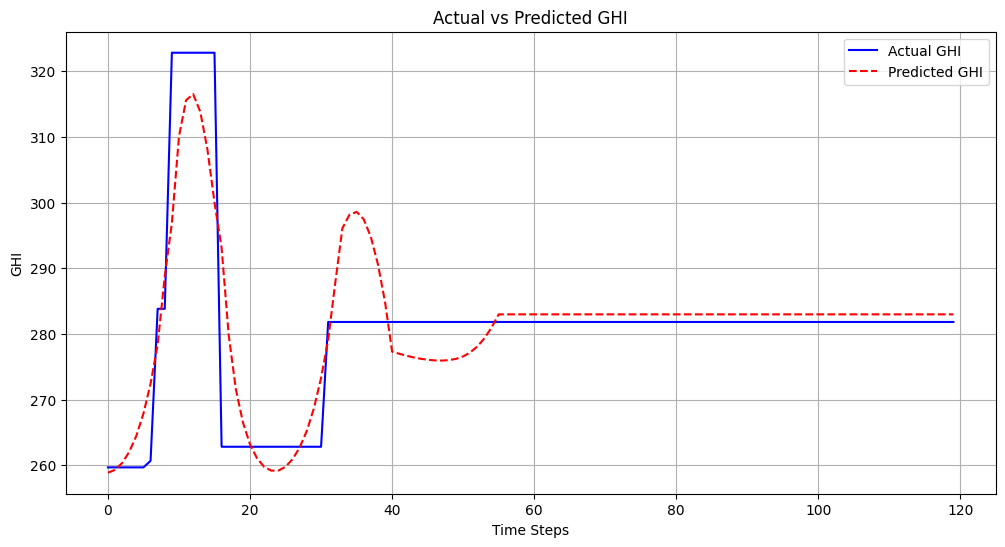

In [121]:
# Import required libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional

# Step 1: Prepare univariate data (GHI)
data = read_data()
y = data[['GHI']].values  # Extract GHI column as numpy array

# Split data into train and test sets
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
train_data, test_data = y[:train_size], y[train_size:]

# Step 2: Train GBDT
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)
X_train_gbdt = np.arange(len(train_data)).reshape(-1, 1)  # Index as a dummy feature for GBDT
gbdt.fit(X_train_gbdt, train_data)

# GBDT predictions for train and test
gbdt_output_train = gbdt.predict(X_train_gbdt).reshape(-1, 1)
X_test_gbdt = np.arange(len(test_data)).reshape(-1, 1)
gbdt_output_test = gbdt.predict(X_test_gbdt).reshape(-1, 1)

# Step 3: Scale the GBDT predictions
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train)
gbdt_output_test_scaled = scaler.transform(gbdt_output_test)

# Step 4: Create datasets with time steps
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 24
X_train, y_train = create_dataset(gbdt_output_train_scaled, time_step)
X_test, y_test = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 5: Define and train the BiLSTM model
def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True, input_shape=(time_step, 1))))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_bilstm_model(time_step)

# Train the model
batch_size = 64
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Step 6: Predictions and inverse scaling
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)  # Inverse transform predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values

# Step 7: Plot Actual vs Predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual GHI', color='blue')
plt.plot(predictions, label='Predicted GHI', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('GHI')
plt.title('Actual vs Predicted GHI')
plt.legend()
plt.grid(True)
plt.show()
